Please run the following in a Terminal first:

pip install matplotlib

pip install seaborn

In [10]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": 54.3213,
	"longitude": 10.1349,
	"hourly": ["temperature_2m", "relative_humidity_2m", "precipitation", "rain"],
	"timezone": "Europe/Berlin"
}
responses = openmeteo.weather_api(url, params=params)

In [5]:
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

Coordinates 54.31999969482422°E 10.139999389648438°N
Elevation 15.0 m asl
Timezone b'Europe/Berlin' b'CET'
Timezone difference to GMT+0 3600 s


In [6]:
# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(2).ValuesAsNumpy()
hourly_rain = hourly.Variables(3).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s"),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain

In [7]:
hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

                   date  temperature_2m  relative_humidity_2m  precipitation  \
0   2023-11-28 23:00:00           -3.15                  89.0            0.5   
1   2023-11-29 00:00:00           -3.05                  92.0            0.9   
2   2023-11-29 01:00:00           -3.20                  92.0            0.6   
3   2023-11-29 02:00:00           -2.90                  93.0            0.5   
4   2023-11-29 03:00:00           -2.10                  93.0            1.2   
..                  ...             ...                   ...            ...   
163 2023-12-05 18:00:00            0.75                  98.0            0.7   
164 2023-12-05 19:00:00            0.95                  97.0            0.5   
165 2023-12-05 20:00:00            1.20                  94.0            0.5   
166 2023-12-05 21:00:00            1.45                  92.0            0.5   
167 2023-12-05 22:00:00            1.75                  90.0            0.3   

     rain  
0     0.0  
1     0.0  
2  

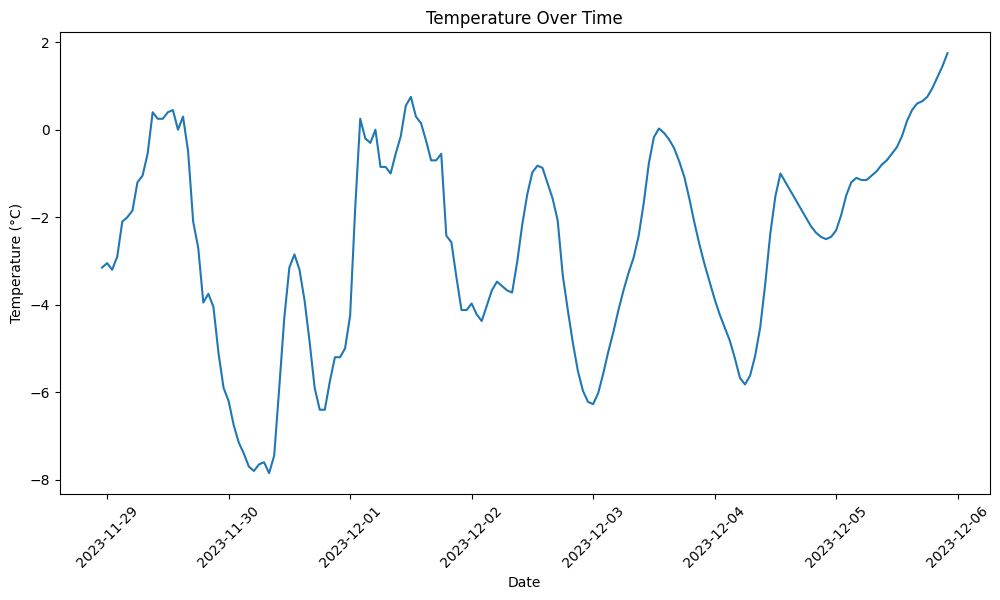

In [11]:
# Line plot for temperature over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='temperature_2m', data=hourly_dataframe)
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.show()

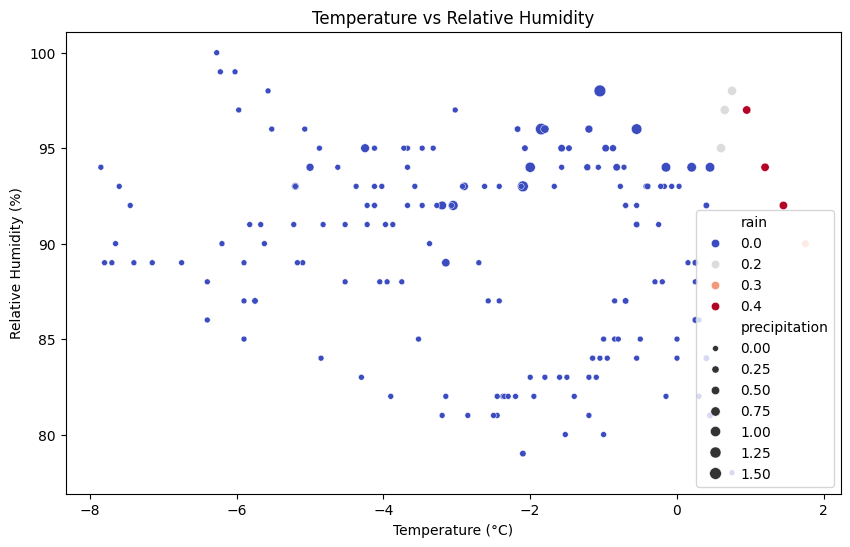

In [13]:
# Scatter plot for temperature and relative humidity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temperature_2m', y='relative_humidity_2m', data=hourly_dataframe, hue='rain', palette='coolwarm', size='precipitation')
plt.title('Temperature vs Relative Humidity')
plt.xlabel('Temperature (°C)')
plt.ylabel('Relative Humidity (%)')
plt.show()